## Landcover mapping using hyperspectral imagery and deep learning

## Introduction

The main difference between multispectral and hyperspectral is the number of bands and how narrow the bands are.

##### <center> Multispectral imagery<centre>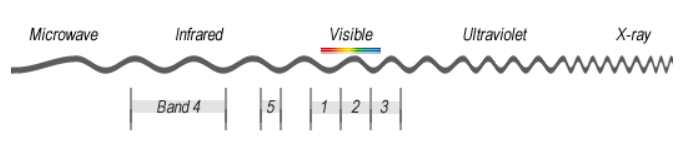

##### <center> Hyperspectral imagery<centre>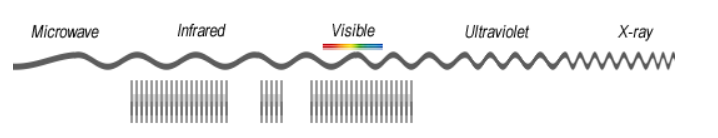

The [Earth Observing-1 (EO-1) satellite](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-earth-observing-one-eo-1-hyperion?qt-science_center_objects=0#qt-science_center_objects) was launched November 21, 2000 as a one-year technology demonstration/validation mission. After the initial technology mission was completed, NASA and the USGS agreed to the continuation of the EO-1 program as an Extended Mission. The EO-1 Extended Mission is chartered to collect and distribute Hyperion hyperspectral and Advanced Land Imager (ALI) multispectral products according to customer tasking requests.

Hyperion collects 220 unique spectral channels ranging from 0.357 to 2.576 micrometers with a 10-nm bandwidth. The instrument operates in a pushbroom fashion, with a spatial resolution of 30 meters for all bands. The standard scene width is 7.7 kilometers.

Hyperion imagery is used in the current analysis to classify the landcover. The data can be downloaded from USGS [earth explorer](https://earthexplorer.usgs.gov/). The spatial resolution of Hyperion data product is $30m^2$.

## Download data

Login to the earth explorer using the usgs credentials, Select Address/Place option in Geocoding method tab and write the name of area of interest.

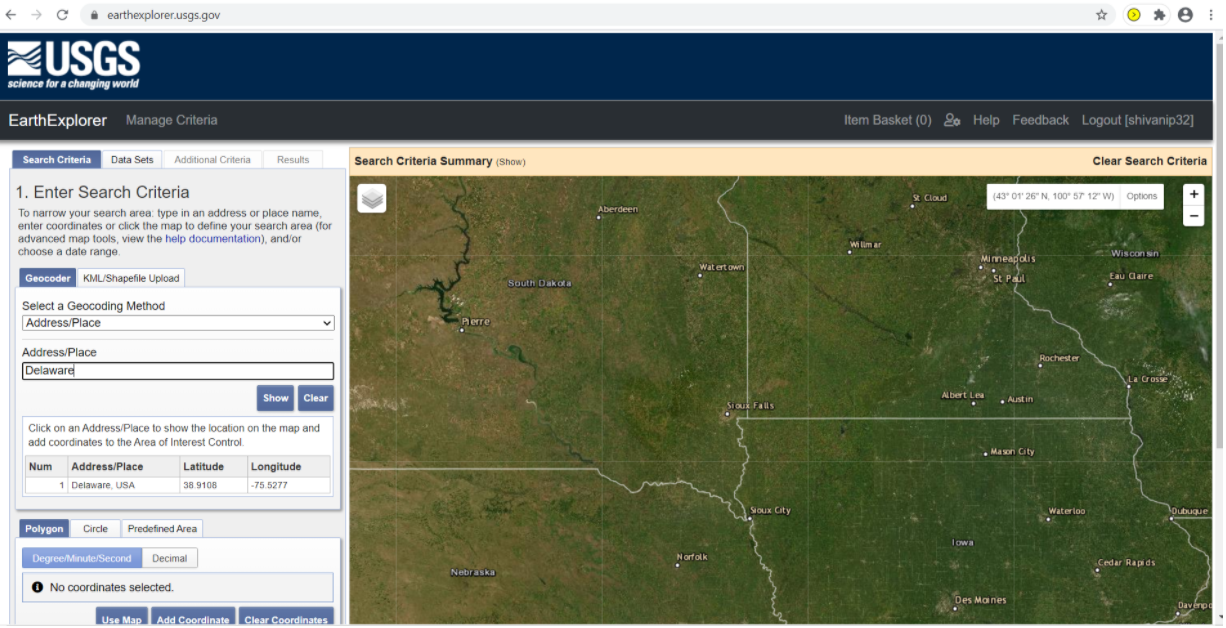

Draw polygon over the area of interest, Change the Cloud Cover Range to 0% - 10%. Click on Results in the bottom left.

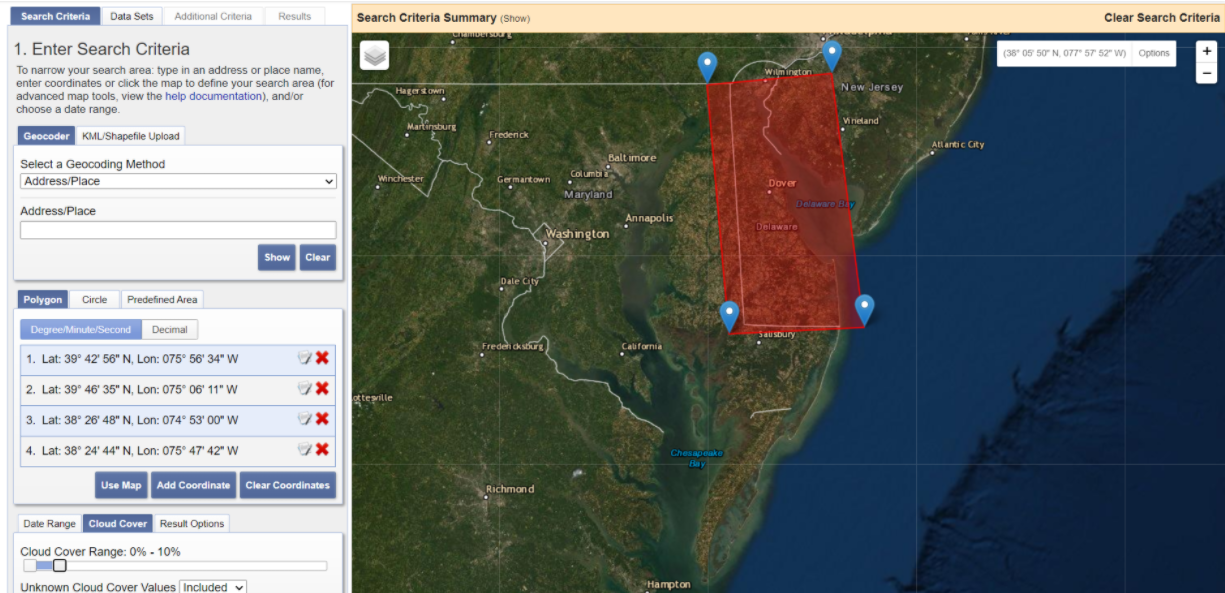

Click on EO-1, select EO-1 Hyperion and click on Results.

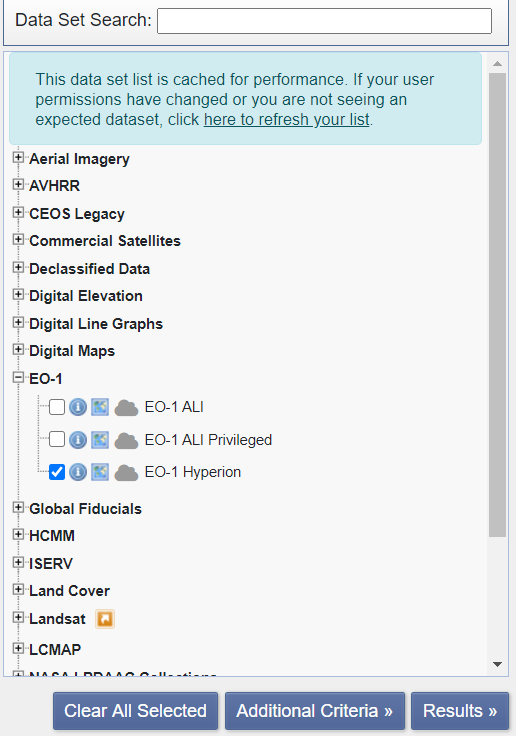

Download data from the product list

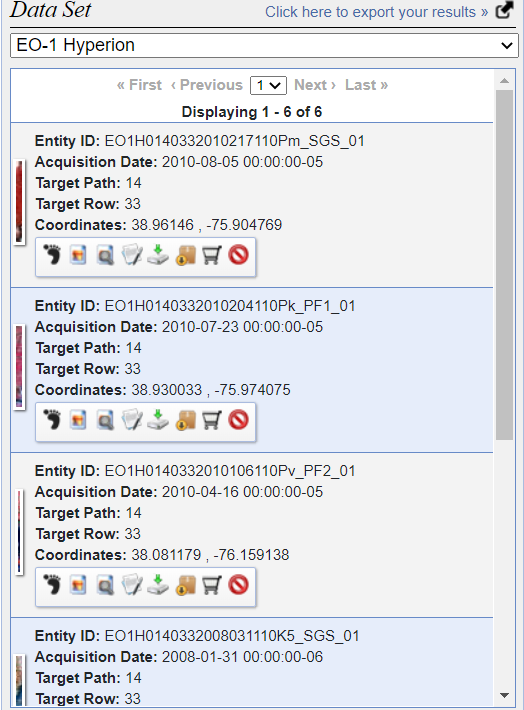

## Pre processing 

### Remove bad bands

Not all bands are useful for analysis. Bad bands are primarily water vapor bands consists inforation about atmosphere, that cause spikes in the reflectance curve. List of bad bands of the Hyperion sensor, L1R product are:
1 to 7 - Not illuminated

58 to 78 - Overlap region

120 to 132 - Water vapor absorption band

165 to 182 - Water vapor absorption band

185 to 187 - Identified by Hyperion bad band list

221 to 224 - Water vapor absorption band

225 to 242 - Not illuminated

Bands with vertical stripping - (8-9, 56-57, 78-82, 97-99, 133-134, 152-153, 188, 213-216, 219-220) 

### Create composite rasters

Two sets of composite rasters were created using [Composite bands function](https://pro.arcgis.com/en/pro-app/help/data/imagery/composite-bands-function.htm). The band range of two raster composites are as follows:

NIR & visible composite - 9 to 55

SWIR composite - 82-96, 100-119, 135-164, 183-184, 189-212, 217-218

Click on Imagery tab -> click on Raster Functions -> Search "Composite Bands" -> Click on browse button and select the bands -> After selecting the bands, click on Create new layer.

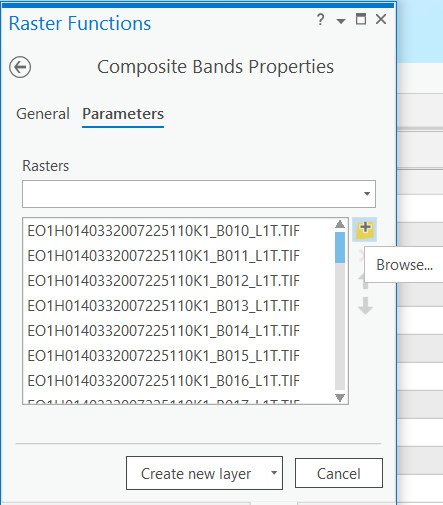

### Convert DN values to at-sensor radiance

Scale factors were used to convert the pixel DN value to at-sensor radiance. Scale factor of 40 was used for VNIR composite raster and 80 was used for SWIR composite. The rasters were divided by the scale factor using [Raster Calculator](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/raster-calculator.htm) tool in ArcGIS Pro.

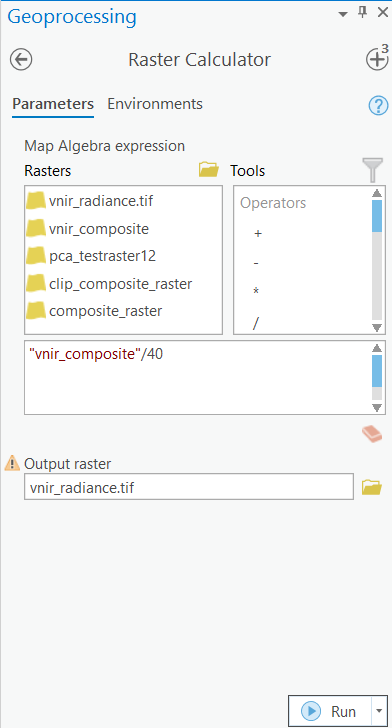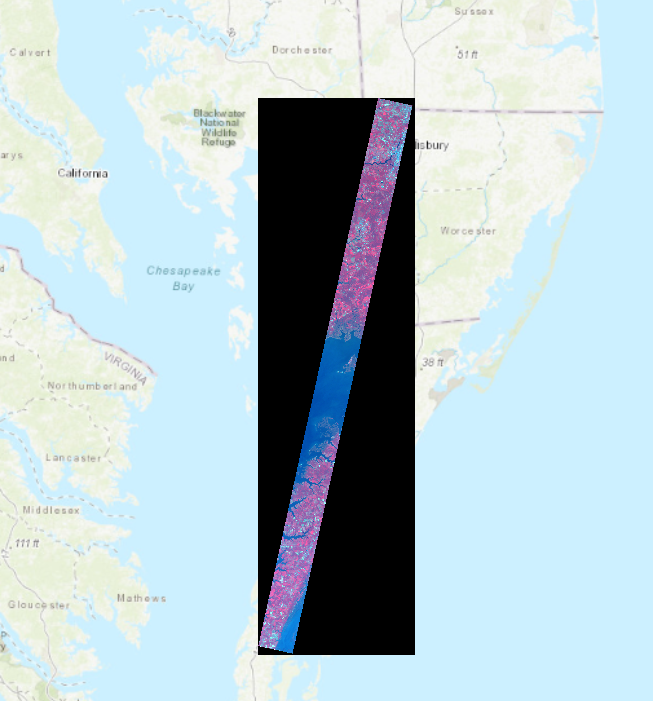

### Create combined composite raster

Combine both VNIR and SWIR radiance composite rasters using "Composite Band" function.

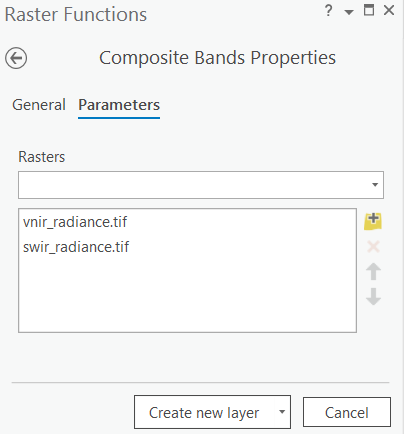

### Eliminate NoData pixel

#### Create null raster

The output raster has 0 pixel value for NoData which are shown as black pixels. The NoData pixels are eliminated using [Set Null](https://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/set-null.htm).

Set the parameters as: -

Raster: combined_composite

False raster = 0

Cellsize Type = Max Of

Extent Type = Intersection Of

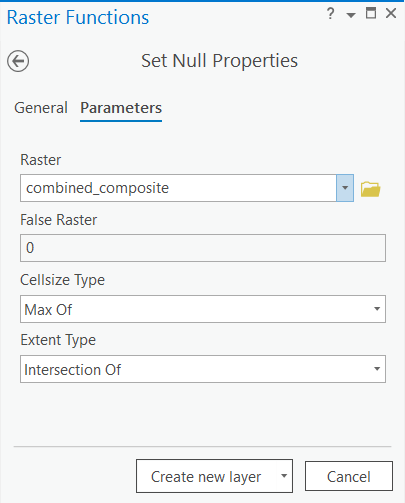

#### Clip

[Clip](https://pro.arcgis.com/en/pro-app/help/data/imagery/clip-function.htm) function was used to eliminate NoData from combined composite raster using null raster which was created in previous step.

Parameters:

Raster: combined_composite

Clipping Type: Outside

Clipping Geometry/Raster: null_raster

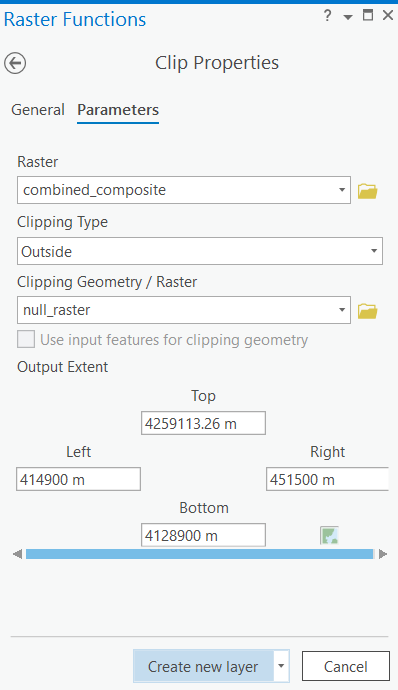

### Principal Component Analysis

Hyperion has 224 bands to get the bands which have comparatively higher information were selected using Principal component analysis. [Principal component](https://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/principal-components.htm) performs Principal Component Analysis (PCA) on a set of raster bands and generates a single multiband raster as output. The value specified for the number of principal components determines the number of principal component bands in the output multiband raster. The number must not be larger than the total number of raster bands in the input. 

Parameters:

Input raster bands: Clip_combined_composite

Number of Principal components: 12 (12 Principal component were chosen because they covers more than 98% of the total variance)

The output raster will have 12 bands representing 12 Principal components.

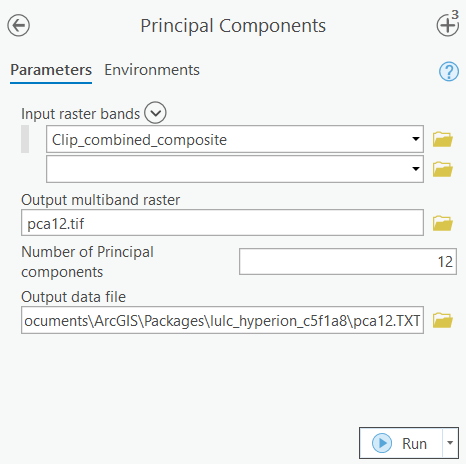

## Export training data

[Export training data for deep learning](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) was used for training data preparation. 

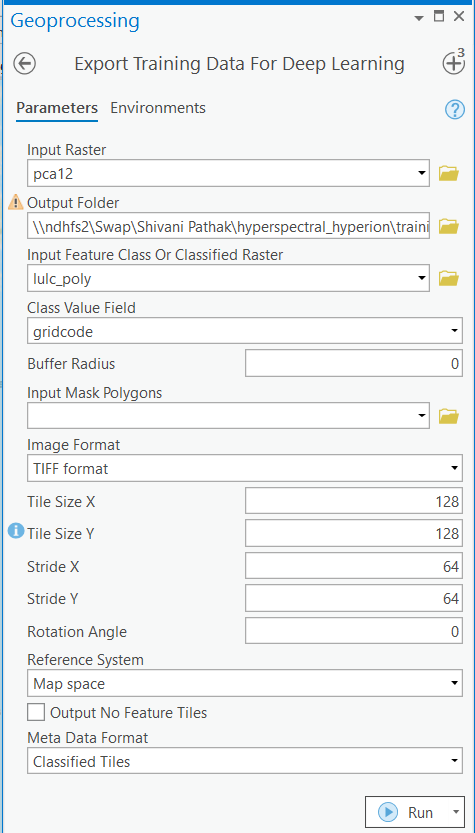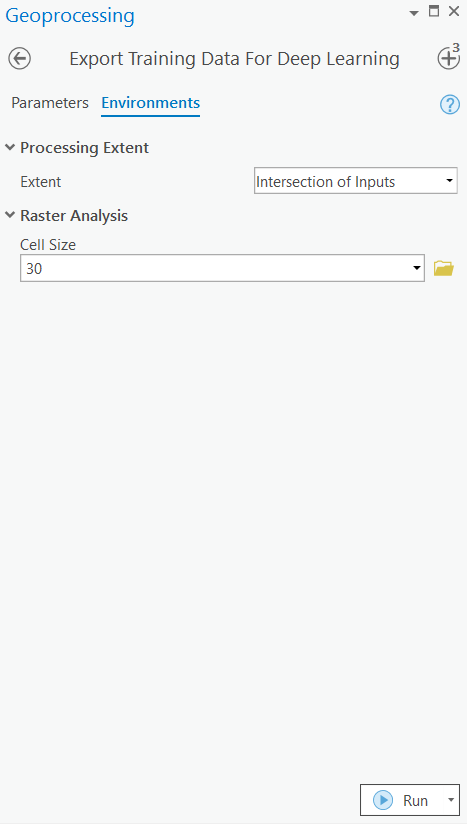

## Train deep learning model

In [1]:
import arcgis
from arcgis.learn import prepare_data, PSPNetClassifier

In [2]:
data = prepare_data(r"\\ndhfs2\Swap\Shivani Pathak\hyperspectral_hyperion\training_data_12_hyperion_30m_128px_64strd", 
                    imagery_type='ms', 
                    batch_size=8)

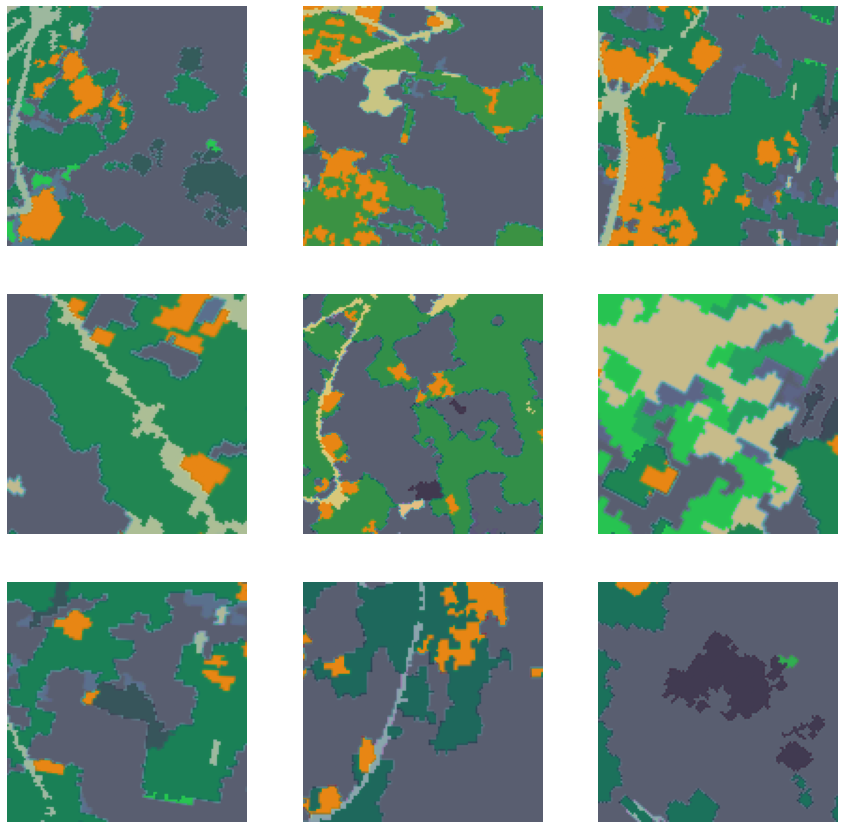

In [9]:
data2.show_batch()

In [15]:
pspnet = PSPNetClassifier(data2)

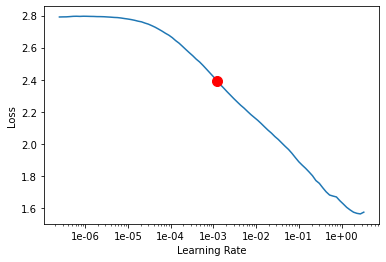

0.001202264434617413

In [16]:
pspnet.lr_find()

In [13]:
pspnet.fit(40, lr=0.0008)

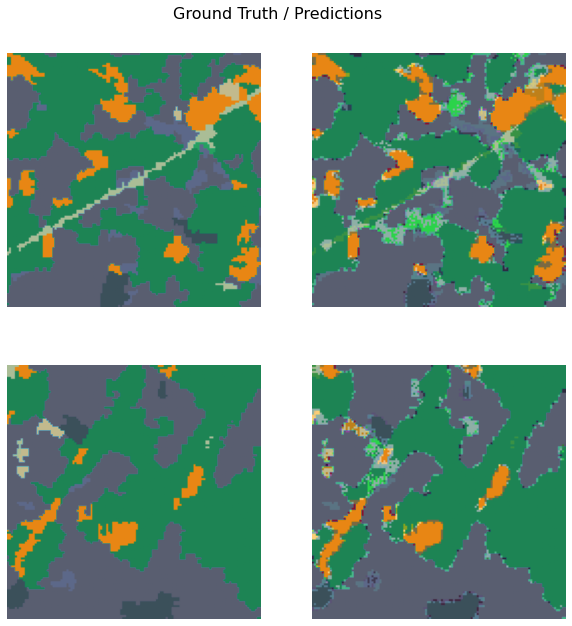

In [14]:
#10e results
pspnet.show_results()

In [8]:
pspnet.fit(90, lr=0.0008)

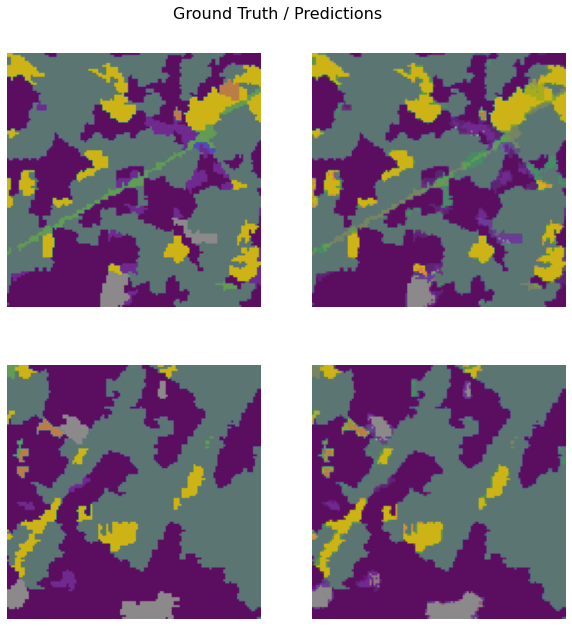

In [9]:
#50e results
pspnet.show_results()

In [10]:
pspnet.per_class_metrics()

NoData         1         2         3    4    5         6         7  \
precision     0.0  0.942871  0.480008  0.909602  0.0  0.0  0.958321  0.167132   
recall        0.0  0.975824  0.390758  0.650641  0.0  0.0  0.946056  0.222365   
f1            0.0  0.958915  0.406353  0.753004  0.0  0.0  0.952145  0.184102   

                  8         9   10  
precision  0.456967  0.837874  0.0  
recall     0.275768  0.918205  0.0  
f1         0.343914  0.876179  0.0

In [11]:
pspnet.fit(50, lr=0.0008)

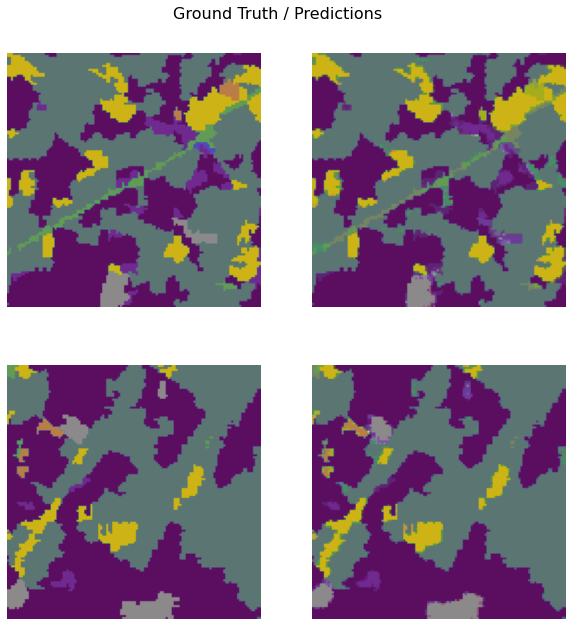

In [12]:
#30e results
pspnet.show_results()